$$A\mathbf{u} + B\mathbf{v} = \mathbf{f}_1$$
$$C\mathbf{u} + D\mathbf{v} = \mathbf{f}_2$$

$$(A + L_\mathbf{u}\mathbb{I})\mathbf{u}^k =  \mathbf{f}_1 - B\mathbf{v}^k + L_\mathbf{u} \mathbf{u}^{k-1}$$
$$(C + D\mathbb{D}^{-1}B + L_\mathbf{v}\mathbb{I})\mathbf{v}^k = \mathbf{f}_2 + D\mathbb{D}^{-1}\mathbf{f}_1 - \mathbb{D}^{-1}\mathbf{h}^{k-1} + L_\mathbf{v} \mathbf{v}^{k-1} $$
$$\mathbf{h}^i := (A-\mathbb{D})\mathbf{u}^i$$

In [10]:
import scipy.sparse as sparse
import scipy.linalg as linalg
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import numpy as np

In [14]:
def generateInvRandomMatrices(size):
    density = 0.3
    diag = 0.9
    X = sparse.identity(2*size).multiply(diag)
    Y = sparse.rand(2*size, 2*size, density=density, format="csr", random_state=55)
    Y = sparse.triu(Y)
    Z = X + Y
    if False: #columns shuffle
        Z = Z.todense()
        Z = Z[:, np.random.permutation(Z.shape[1])]
        Z =  sparse.csc_matrix(Z)
    A = Z[:size,:size]
    B = Z[:size,size:]
    C = Z[size:,:size]
    D = Z[size:,size:]
    return A, B, C, D, Z

def solveP0(A, B, Lu, v1, u0, f1):
    u = spsolve(A + sparse.identity(A.shape[0]).multiply(Lu), f1 - B.dot(v1) + Lu*u0)
    return u

def solveP1(A, B, C, D, Lv, u0, v0, f1, f2, opD, invOpD):
    M = C + D.dot(invOpD).dot(B) + sparse.identity(C.shape[0]).multiply(Lv)
    h = (A - opD).dot(u0)
    f = f2 + D.dot(invOpD).dot(f1) - invOpD.dot(h) + Lv*v0
    v = spsolve(M, f)
    return v

def method0(**kwargs):
    print("method 0")
    A = kwargs['A']
    B = kwargs['B']
    C = kwargs['C']
    D = kwargs['D']    
    f1 = kwargs['f1']
    f2 = kwargs['f2']
    Z = kwargs['Z']
    nit = kwargs['nit']

    f = np.concatenate((f1,f2))
    sol = spsolve(Z, f)
    print(f"monolitic error = {np.linalg.norm(f-Z.dot(sol))}")
    
    Lu = kwargs['Lu']
    Lv = kwargs['Lv']
    
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    for i in range(nit):
        v = spsolve(D, f2 - C.dot(u))
        u = spsolve(A + sparse.identity(A.shape[0]).multiply(Lv), f1 - B.dot(v) + Lv*v)
        print(f"it={i}   residual={np.linalg.norm(sol - np.concatenate((v,u)))}")

    return u, v, sol
    
    
def method1(**kwargs):
    print("method 1")
    A = kwargs['A']
    B = kwargs['B']
    C = kwargs['C']
    D = kwargs['D']
    Lu = kwargs['Lu']
    Lv = kwargs['Lv']
    f1 = kwargs['f1']
    f2 = kwargs['f2']
    Z = kwargs['Z']
    
    f = np.concatenate((f1,f2))
    sol = spsolve(Z, f)
    print(f"monolitic error = {np.linalg.norm(f-Z.dot(sol))}")
    
    opD = np.zeros(A.shape)
    np.fill_diagonal(opD, A.diagonal())
    opD = opD + 1*np.eye(A.shape[0])
    invOpD = sparse.csc_matrix(np.linalg.inv(opD))
    opD = sparse.csc_matrix(opD)

    nit = kwargs['nit']
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    for i in range(nit):
        v = solveP1(A, B, C, D, Lv, u, v, f1, f2, opD, invOpD)
        u = solveP0(A, B, Lu, v, u, f1)
        print(f"it={i}   res={np.linalg.norm(sol - np.concatenate((u,v)))}")
    return u, v, opD, invOpD, sol

In [15]:
size = 20
A, B, C, D, Z = generateInvRandomMatrices(size)
Lu = 0.0
Lv = 1.0
f1 = np.random.rand(size)
f2 = np.random.rand(size)
nit = 5

print("determinant of Z =", linalg.det(Z.todense()))

print()

u_m0, v_m0, sol_m0 = method0(A=A, B=B, C=C, D=D, f1=f1, f2=f2, nit=nit, Z=Z, Lu=Lu, Lv=Lv)

print()

u_m1, v_m1, opD, invOpD, sol_m1 = method1(A=A, B=B, C=C, D=D, Lu=Lu, Lv=Lv, f1=f1, f2=f2, nit=nit, Z=Z)

determinant of Z = 1.8894796893179218

method 0
monolitic error = 1.7787946215439797e-15
it=0   residual=8.417196467601855
it=1   residual=8.417196467601855
it=2   residual=8.417196467601855
it=3   residual=8.417196467601855
it=4   residual=8.417196467601855

method 1
monolitic error = 1.7787946215439797e-15
it=0   res=6.424960702155291
it=1   res=12.070749853200121
it=2   res=27.07004419040814
it=3   res=103.91762177892923
it=4   res=345.3801376154593


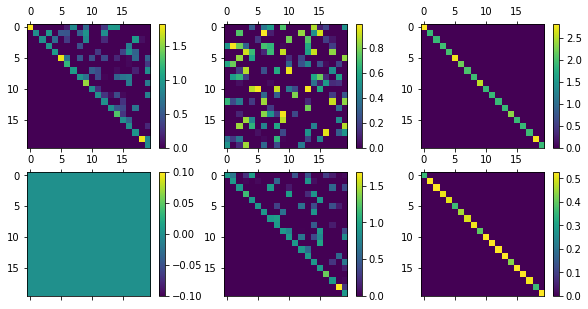

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(10,5))
cax1 = axs[0,0].matshow(A.todense())
cax2 = axs[0,1].matshow(B.todense())
cax3 = axs[1,0].matshow(C.todense())
cax4 = axs[1,1].matshow(D.todense())
cax5 = axs[0,2].matshow(opD.todense())
cax6 = axs[1,2].matshow(invOpD.todense())
fig.colorbar(cax1, ax=axs[0,0])
fig.colorbar(cax2, ax=axs[0,1])
fig.colorbar(cax3, ax=axs[1,0])
fig.colorbar(cax4, ax=axs[1,1])
fig.colorbar(cax5, ax=axs[0,2])
fig.colorbar(cax6, ax=axs[1,2])

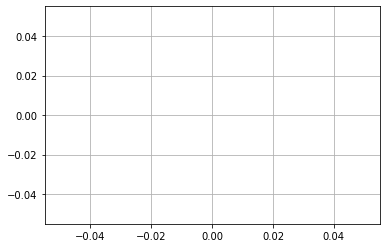

In [9]:
uv_m0 = np.concatenate((u_m0,v_m0))
uv_m1 = np.concatenate((u_m1,v_m1))

plt.plot()
plt.grid()
plt.show()